In [1]:
#!/usr/bin/env python3
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from binary_classifier.classifier import Predicter

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
from PIL import Image, ImageFilter
import cv2
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep
import matplotlib.patches as mpatches
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

In [3]:
tiles_dir = "/home/bota/Downloads/projtiles1/"
gps_csv = "/home/bota/Desktop/active_sensing/data/gpstiles.csv"
raw_imgs_dir = "/media/bota/BOTA/wheat/APPEZZAMENTO_PICCOLO/"

pred_file = "/home/bota/Desktop/active_sensing/data/prediction_on_tiles.pickle"
gtfile_path = "annotation.txt"

In [4]:
gt_matrix = np.loadtxt(gtfile_path, dtype=int)
rows = range(3, 113)
cols = range(13, 73)

In [5]:
from binary_classifier.dataloader import WheatOthomapDataset

annotation_path = "/home/bota/Desktop/active_sensing/src/annotation.txt"
dataset_path = "/media/bota/BOTA/wheat/example-run-001_20241014T1739_ortho_dsm.tif"
tile_ortomappixel_path = "/home/bota/Desktop/active_sensing/data/tomatotiles.txt"

all_data = WheatOthomapDataset(dataset_path, annotation_path, tile_ortomappixel_path)

/home/bota/Desktop/active_sensing/.venv/lib/python3.10/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# Orthomap predictions

In [6]:
# Predict using othomap trained model
def predict_othomap(predictor):
    predictions_orto = {}
    batch_size = 128  # Define the maximum number of images per batch for predict_batch
    tiles = [(row, col) for row in range(3, 113) for col in range(13, 73)]
    batched_images = []
    batched_tiles = []
    pbar = tqdm(total=len(tiles))
    true_labels = []
    for tile_to_test in tiles:
        tile_img, tile_label = all_data.get_tile_info(tile_to_test)
        batched_images.append(tile_img)
        batched_tiles.append(tile_to_test)
        true_labels.append(tile_label)

        # Process the batch if it reaches the batch_size or if it's the last tile
        if len(batched_images) >= batch_size or tile_to_test == tiles[-1]:
            batch_predictions = predictor.predict_batch(
                batched_images
            )  # Predict for the batched images

            # Assign predictions back to their respective tiles
            for tile, prediction in zip(batched_tiles, batch_predictions):
                if tile not in predictions_orto:
                    predictions_orto[tile] = []
                predictions_orto[tile].append(prediction)

            # Clear the batch
            batched_images.clear()
            batched_tiles.clear()

        sleep(0.01)
        pbar.update(1)

    pbar.close()
    return predictions_orto, true_labels


def evaluate_confusion_matrix(pred_matrix, true_matrix, plot=True):
    # Flatten matrices to 1D arrays for evaluation
    y_pred = pred_matrix.flatten()
    y_true = true_matrix.flatten()

    # Compute confusion matrix
    labels = [0, 1]  # Classes: 0, 1, 2
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Convert confusion matrix to percentages
    confusion_mat_percent = cm / cm.sum(axis=1, keepdims=True) * 100
    print(f"Confusion Matrix (Percentage):\n{confusion_mat_percent}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(
        y_true, y_pred, average="weighted"
    )  # Use 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Display confusion matrix
    if plot:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=["lodged", "not lodged"],
        )
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    return cm


def evaluate_model(predictions_orto, true_labels, plot=True):
    rows = range(3, 113)
    cols = range(13, 73)
    pred_matrix = np.zeros((len(rows), len(cols)))
    true_matrix = np.zeros((len(rows), len(cols)))
    difference_matrix = np.zeros((len(rows), len(cols)))
    # Populate the raw_img_counts and persistence arrays
    for (row, col), preds in predictions_orto.items():
        row_idx = row - 3
        col_idx = col - 13
        pred = np.argmax(preds[0])
        # print(f"pred init:{preds} with argmax result:{arg}")

        pred_matrix[row_idx, col_idx] = pred
        true_matrix[row_idx, col_idx] = true_labels[row_idx * len(cols) + col_idx]
    difference_matrix = pred_matrix - true_matrix
    # Example usage:
    conf_matrix = evaluate_confusion_matrix(pred_matrix, true_matrix, plot=plot)
    if plot:

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(true_matrix, aspect="auto", cmap="plasma", origin="lower")
        plt.colorbar(label="labels")
        plt.gca().invert_yaxis()
        plt.title("Ground Truth Per Tile")
        plt.xlabel("Column Index")
        plt.ylabel("Row Index")
        plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
        plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

        plt.subplot(1, 3, 2)
        plt.imshow(pred_matrix, aspect="auto", cmap="plasma", origin="lower")
        plt.colorbar(label="Prediction Label")
        plt.title("Prediction std Per Tile")
        plt.xlabel("Column Index")
        plt.ylabel("Row Index")
        plt.gca().invert_yaxis()
        plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
        plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

        plt.subplot(1, 3, 3)
        plt.imshow(difference_matrix, aspect="auto", cmap="viridis", origin="lower")
        plt.colorbar(label="diff")
        plt.title("Difference Per Tile")
        plt.xlabel("Column Index")
        plt.ylabel("Row Index")
        plt.gca().invert_yaxis()
        plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
        plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

        # Show the plots
        plt.tight_layout()
        plt.show()
    else:
        print(conf_matrix)

100%|██████████| 6600/6600 [01:28<00:00, 74.83it/s]

Confusion Matrix (Percentage):
[[93.10113865  6.89886135]
 [ 2.74133542 97.25866458]]
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


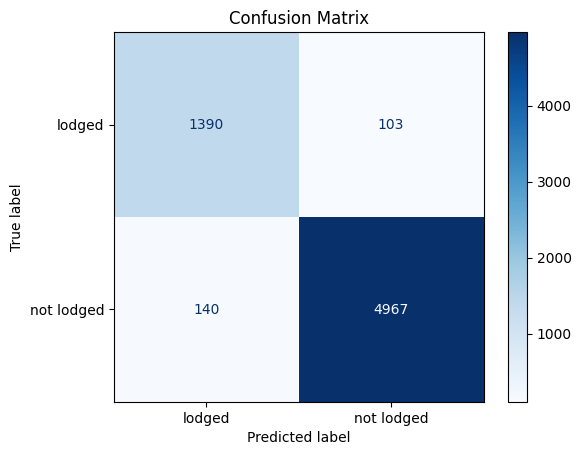

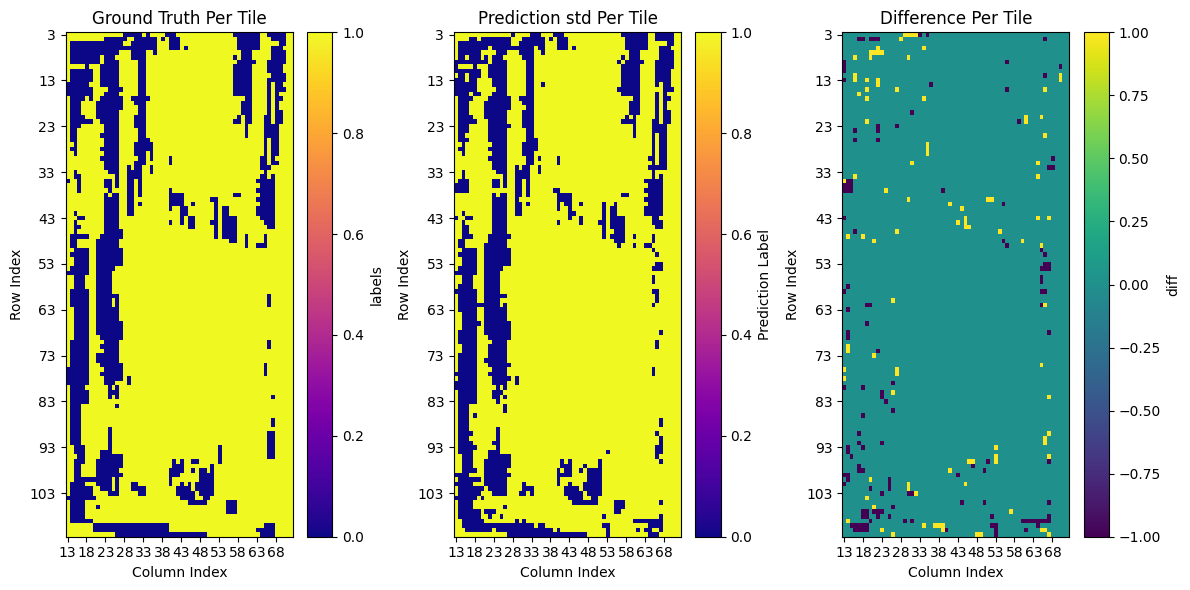

In [7]:
model_path = "/home/bota/Desktop/active_sensing/binary_classifier/models/best_model_auc91_lr1_-05_bs128_wd_2.5-04.pth"

predictor = Predicter(model_weights_path=model_path, num_classes=2)
predictions_orto, true_labels = predict_othomap(predictor)
evaluate_model(predictions_orto, true_labels, plot=True)

# Blurred(h) orthomap predictions

h= [20, 26.5, 32, 38.5, 45, 51.5]

In [8]:
class img_sampler:
    def __init__(self):
        self.focal_length = 0.01229  # 12.29mm lens in meters
        self.sensor_width = 0.017424  # sensor width in meters
        self.sensor_height = 0.0130548  # sensor height in meters
        self.resolution_x = 5280  # horizontal resolution (number of pixels)
        self.resolution_y = 3956  # vertical resolution (number of pixels)
        self.fov_h, self.fov_v = self.calculate_fov()

    def calculate_fov(self):
        fov_horizontal = 2 * math.atan(self.sensor_width / (2 * self.focal_length))
        fov_vertical = 2 * math.atan(self.sensor_height / (2 * self.focal_length))
        return fov_horizontal, fov_vertical

    # Function to calculate the size of a 1m x 1m tile on the image in pixels
    def calculate_tile_size_on_image(self, altitude):
        # Calculate ground coverage at altitude
        coverage_horizontal = 2 * math.tan(self.fov_h / 2) * altitude
        coverage_vertical = 2 * math.tan(self.fov_v / 2) * altitude

        # Calculate tile size on image in pixels (1m x 1m tile)
        tile_size_image_horizontal = self.resolution_x / coverage_horizontal
        tile_size_image_vertical = self.resolution_y / coverage_vertical

        return int(tile_size_image_horizontal), int(tile_size_image_vertical)

    # Function to calculate the altitude from FOV and tile size on the image
    def calculate_altitude_from_fov_and_tile_size(self, size):
        tile_size_image_horizontal, tile_size_image_vertical = size
        # Calculate the ground coverage corresponding to the pixel size of the tile on the image
        coverage_horizontal = self.resolution_x / tile_size_image_horizontal
        coverage_vertical = self.resolution_y / tile_size_image_vertical

        # Calculate the altitude based on horizontal and vertical coverage
        altitude_horizontal = coverage_horizontal / (2 * math.tan(self.fov_h / 2))
        altitude_vertical = coverage_vertical / (2 * math.tan(self.fov_v / 2))

        # Average the two altitudes for a more accurate result
        altitude = (altitude_horizontal + altitude_vertical) / 2

        return altitude

In [9]:
# Function for downsampling with Gaussian blur, with adjustable blur based on size
def downsample_with_blur(image, target_size, original_size):
    # Calculate blur strength based on size difference
    blur_radius = max(0.5, abs(original_size[0] - target_size[0]) / 50)
    # blur_radius = max(0.5, (original_size[0] / target_size[0]) * 2)

    blurred = image.filter(
        ImageFilter.GaussianBlur(radius=blur_radius)
    )  # Apply Gaussian blur
    return blurred.resize(target_size, Image.LANCZOS)


def plot_alt_pred(predictor, img_path, img_i=None, plot=True):
    if isinstance(img_path, str):
        image = Image.open(img_path)
    else:
        image = img_path
    r0, c0 = image.size
    orig_size = (r0, c0)
    # Generate the 6 images
    alts = [round(s.calculate_altitude_from_fov_and_tile_size(orig_size), 2)]
    sizes = [orig_size]
    images = [image]
    predictions = [predictor.predict(image)]

    for i, h in enumerate(hs):
        target_size = s.calculate_tile_size_on_image(h)
        alts.append(h)
        sizes.append(target_size)
        if target_size[0] < image.size[0] and target_size[1] < image.size[1]:
            images.append(
                downsample_with_blur(image, target_size, orig_size)
            )  # Downsample with blur

        predictions.append(predictor.predict(images[-1]))
    if not plot:
        return predictions

    if plot:
        fig, axes = plt.subplots(1, len(predictions), figsize=(12, 5))
        axes = axes.flatten()
        print(f"raw img [{img_i}]: {img_path}")

        for i, ax in enumerate(axes):
            ax.imshow(images[i])

            if predictions[i][0] == 1:
                pred = "not lodged"
            elif predictions[i][0] == 0:
                pred = "lodged"
            else:
                pred = "other"

            if sizes[i] == orig_size:
                alt = "" + str(alts[i])
            else:
                alt = alts[i]

            ax.set_title(
                f"h={alt}m \n {sizes[i][0]}x{sizes[i][1]} px \n {pred}", fontsize=10
            )
            ax.axis("off")  # Hide axis

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()


def sampled_img_conf_matrix(tile):
    img_path, label = all_data.get_tile_info(tile)
    pred = plot_alt_pred(predictor, img_path, 0, plot=False)
    print(f"tile:{tile} label:{label} predicions:{pred}")


# hs = [20, 25, 30, 35, 40]
hs = [20, 26.5, 32, 38.5, 45, 51.5]
s = img_sampler()
print(s.calculate_tile_size_on_image(20))
# tiles = [(row, col) for row in range(3, 113) for col in range(13, 73)]

(186, 186)


[19.5, 27.29, 35.08, 42.87, 50.66, 58.45]


100%|██████████| 6600/6600 [07:20<00:00, 14.99it/s]


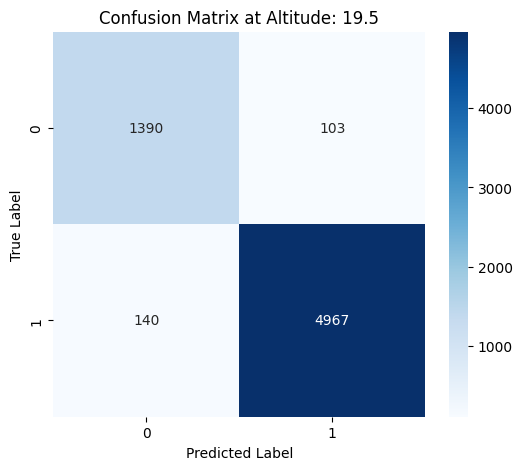

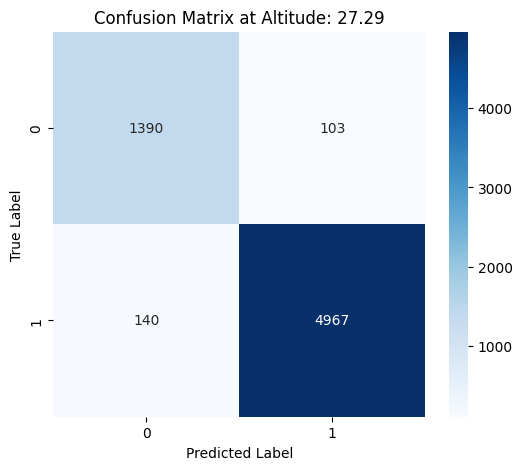

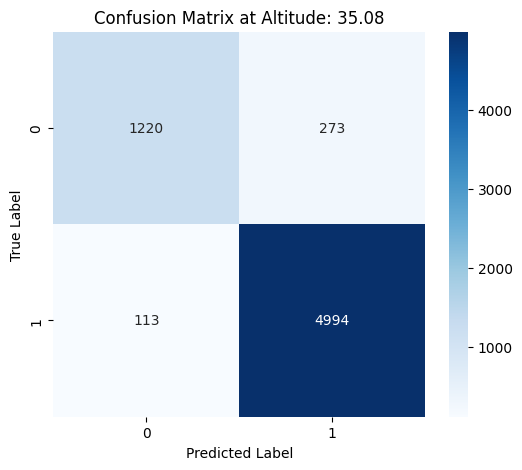

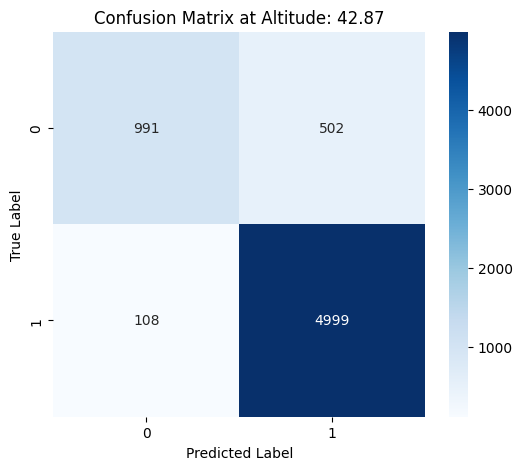

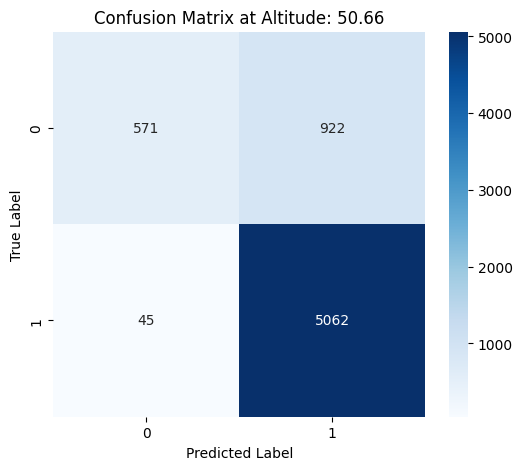

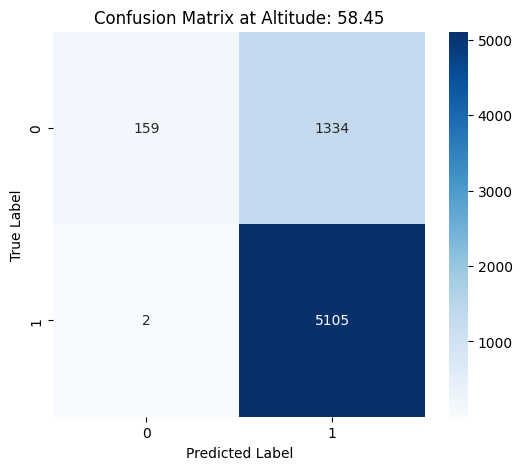

In [11]:
# Altitudes to test
hs = [20, 26.5, 32, 38.5, 45, 51.5]
hs = [round(19.5 + i * 7.79, 2) for i in range(6)]
print(hs)  # Output: [19.5, 27.29, 35.08, 42.87, 50.66, 58.45]

tiles = [(row, col) for row in range(3, 113) for col in range(13, 73)]


# Function to get predictions and store results
def collect_predictions():
    all_predictions = {h: [] for h in hs}
    all_labels = []
    # global all_labels
    pbar = tqdm(total=len(tiles))
    for tile in tiles:
        img_path, label = all_data.get_tile_info(tile)
        all_labels.append(label)

        pred = plot_alt_pred(predictor, img_path, plot=False)
        for i, h in enumerate(hs):
            all_predictions[h].append(pred[i])
        sleep(0.01)
        pbar.update(1)
    pbar.close()
    return all_predictions, all_labels


# Compute accuracy per altitude
def compute_accuracy(all_predictions, all_labels):
    accuracies = {h: accuracy_score(all_labels, all_predictions[h]) for h in hs}

    conf_matrices = {h: confusion_matrix(all_labels, all_predictions[h]) for h in hs}

    false_negatives = {
        h: conf_matrices[h][1, 0] / 1493 for h in hs
    }  # FN = (actual 1, predicted 0)
    false_positives = {
        h: conf_matrices[h][0, 1] / 5107 for h in hs
    }  # FP = (actual 0, predicted 1)

    return accuracies, false_negatives, false_positives


# Plot Confusion Matrix for each altitude
def plot_confusion_matrices():
    for h in hs:
        cm = confusion_matrix(all_labels, all_predictions[h])
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=[0, 1],
            yticklabels=[0, 1],
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix at Altitude: {h}")
        plt.show()


# Main execution
all_predictions, all_labels = collect_predictions()

# plot_accuracy_curve(all_predictions, all_labels)
# plot_confusion_matrices()

In [33]:
def plot_accuracy_curve(all_predictions, all_labels):
    accuracies, false_negatives, false_positives = compute_accuracy(
        all_predictions, all_labels
    )

    # Increase global font size
    plt.rcParams.update({"font.size": 18})

    # Create a single figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy Plot
    axes[0].plot(
        hs,
        list(accuracies.values()),
        marker="o",
        markersize=10,  # Increased marker size
        linestyle="-",
        color="black",
        linewidth=4,  # increased line width
    )
    axes[0].set_xlabel("Altitude", fontsize=18)
    axes[0].set_ylabel("Accuracy", fontsize=18)
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # Error Rate Plot
    axes[1].plot(
        hs,
        list(false_negatives.values()),
        marker="x",
        markersize=10,  # Increased marker size
        linestyle="--",
        color="black",
        label="False Negatives",
        linewidth=4,  # increased line width
    )
    axes[1].plot(
        hs,
        list(false_positives.values()),
        marker="o",
        markersize=10,  # Increased marker size
        linestyle="-",  # Changed to dashed line
        color="black",
        label="False Positives",
        linewidth=4,  # increased line width
    )
    axes[1].set_xlabel("Altitude", fontsize=18)
    axes[1].set_ylabel("Error Rate", fontsize=18)
    axes[1].legend(loc="upper left", fontsize=16)  # Moved legend to top left
    axes[1].grid(True, linestyle="--", alpha=0.6)

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig("/home/bota/Desktop/active_sensing/accuracy_error_plots.png", dpi=300)

    # Show the figure
    plt.show()

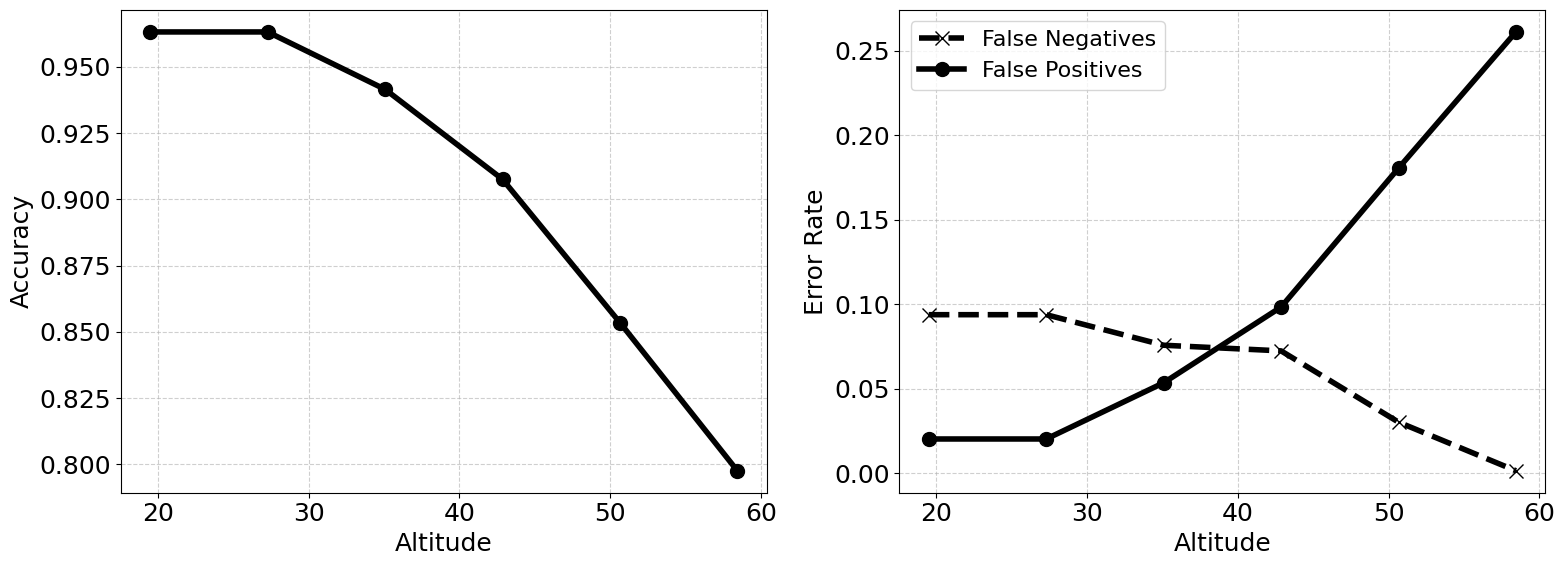

In [34]:
plot_accuracy_curve(all_predictions, all_labels)